In [16]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda
import torch.optim as optim
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.nn.functional import relu
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [17]:
DATA_PATH = "C:/Users/André/OneDrive 2/OneDrive/Skrivebord/bsc_data/latent_space_data/data/"
DATA_LIST = os.listdir(DATA_PATH)
TRAIN_DATA_LIST, VAL_DATA_LIST = train_test_split(DATA_LIST, test_size = 0.2)

In [18]:
class CONV_AE(nn.Module):
    def __init__(self):
        super(CONV_AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(256, 100, 2),
            nn.ReLU(),
            nn.Conv2d(100, 50, 2),
            nn.ReLU(),
            nn.Conv2d(50, 10, 2),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(10, 50, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(50, 100, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(100, 256, 2),
            nn.ReLU()
        )

        # Initialize weights
        self.init_params()
        
    def init_params(self):
        for p in self.parameters():
            if (len(p.shape) > 1):
                nn.init.xavier_normal_(p)

    def encode(self, X):
        return self.encoder(X)

    def decode(self, X):
        return self.decoder(X)

    def add_noise(self, X, fac = 1):
        noise = torch.randn_like(X) * fac
        return X + noise

    def forward(self, X):
        X_noisy = self.add_noise(X)
        X_encoded = self.encode(X_noisy)
        X_decoded = self.decode(X_encoded)
        return X_encoded, X_decoded

In [19]:
LEARNING_RATE = 5e-4
NUM_EPOCHS = 250
MINI_BATCH_SIZE = 16
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AE = CONV_AE().to(device)
optimizer = optim.Adam(AE.parameters(), lr = LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=10, mode = "min", verbose=True)

In [20]:
class dataset(Dataset):
    def __init__(self, PATH, DATA_LIST):
        self.path = PATH
        self.data = DATA_LIST

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return np.load(self.path + self.data[i])

train_dataset = dataset(DATA_PATH, DATA_LIST)
val_dataset = dataset(DATA_PATH, VAL_DATA_LIST)

train_dataloader = DataLoader(train_dataset, batch_size = MINI_BATCH_SIZE)
val_dataloader = DataLoader(val_dataset, batch_size = 1)

In [22]:
torch.cuda.empty_cache()
train_losses = []
val_losses = []

for epoch in tqdm(range(NUM_EPOCHS), desc = "EPOCH"):
    AE.train()
    print("Epoch:", epoch)
    train_losses.append(0)
    for x in tqdm(train_dataloader, desc = "TRAINING", leave = False):

        # Prework
        x = x.to(device, dtype = torch.float)

        # Prediction
        _, decoded = AE(x)

        # Backpropegation
        optimizer.zero_grad()

        # Train loss
        train_loss = criterion(decoded, x)
        train_losses[-1] += train_loss.item()

        # Backpropegation
        train_loss.backward()
        optimizer.step()

    train_losses[-1] /= len(train_dataloader)
    print("     Train loss:", train_losses[-1])

    # Validation
    """
    with torch.no_grad():
        AE.eval()
        val_losses.append(0)
        #for x_val in tqdm(X_val, desc = "Validation", leave = False):
        for x_val in tqdm(val_dataloader, desc = "VALIDATION", leave = False):

            # Prework
            x_val = x_val.to(device, dtype = torch.float)

            # Prediction
            _, decoded = AE(x_val)

            # Validation loss
            val_loss = criterion(decoded, x_val)
            val_losses[-1] += val_loss.item()

    val_losses[-1] /= len(val_dataloader)
    scheduler.step(val_losses[-1])
    print("     Validation loss:", val_losses[-1])
    """

Epoch: 0


     Train loss: 16.970222366697968
Epoch: 1


     Train loss: 16.70153198807006
Epoch: 2


     Train loss: 16.51002565223155
Epoch: 3


     Train loss: 16.379733124735143
Epoch: 4


     Train loss: 16.314169262427676
Epoch: 5


     Train loss: 16.258756253062185
Epoch: 6


     Train loss: 16.214392160228826
Epoch: 7


     Train loss: 16.127673129557476
Epoch: 8


     Train loss: 16.11062090923683
Epoch: 9


     Train loss: 16.061784348889745
Epoch: 10


     Train loss: 16.02972245487917
Epoch: 11


     Train loss: 16.018007765055245
Epoch: 12


     Train loss: 15.99638076469404
Epoch: 13


     Train loss: 15.985770751240585
Epoch: 14


     Train loss: 15.965445173085415
Epoch: 15


     Train loss: 15.937937043522377
Epoch: 16


     Train loss: 15.906676607414367
Epoch: 17


     Train loss: 15.883659901542924
Epoch: 18


     Train loss: 15.876603960719358
Epoch: 19


     Train loss: 15.837500778580582
Epoch: 20


     Train loss: 15.779321907321522
Epoch: 21


     Train loss: 15.771394760027562
Epoch: 22


     Train loss: 15.758275490415395
Epoch: 23


     Train loss: 15.747496604919434
Epoch: 24


     Train loss: 15.686657862131037
Epoch: 25


     Train loss: 15.66989333428663
Epoch: 26


     Train loss: 15.662488659313437
Epoch: 27


     Train loss: 15.656053380162406
Epoch: 28


     Train loss: 15.652563733772157
Epoch: 29


     Train loss: 15.651390377644255
Epoch: 30


     Train loss: 15.645715161716748
Epoch: 31


     Train loss: 15.643357674461834
Epoch: 32


     Train loss: 15.642555199885965
Epoch: 33


     Train loss: 15.638156052330903
Epoch: 34


     Train loss: 15.626141157128545
Epoch: 35


     Train loss: 15.582617727118906
Epoch: 36


     Train loss: 15.576738314096369
Epoch: 37


     Train loss: 15.571796428098223
Epoch: 38


     Train loss: 15.567293786242232
Epoch: 39


     Train loss: 15.563996039110327
Epoch: 40


     Train loss: 15.561463940387977
Epoch: 41


     Train loss: 15.559089704092107
Epoch: 42


     Train loss: 15.555401641306954
Epoch: 43


     Train loss: 15.554103279982721
Epoch: 44


     Train loss: 15.551938139496198
Epoch: 45


     Train loss: 15.550418093427167
Epoch: 46


     Train loss: 15.473528047357442
Epoch: 47


     Train loss: 15.462744078494964
Epoch: 48


     Train loss: 15.459906308688987
Epoch: 49


     Train loss: 15.458588048374462
Epoch: 50


     Train loss: 15.457448544426224
Epoch: 51


     Train loss: 15.456959565842613
Epoch: 52


     Train loss: 15.458090069625264
Epoch: 53


     Train loss: 15.443733699772515
Epoch: 54


     Train loss: 15.440008528411795
Epoch: 55


     Train loss: 15.437276447009388
Epoch: 56


     Train loss: 15.435790118432534
Epoch: 57


     Train loss: 15.43441831984118
Epoch: 58


     Train loss: 15.432218314846446
Epoch: 59


     Train loss: 15.415966857267133
Epoch: 60


     Train loss: 15.409073684101497
Epoch: 61


     Train loss: 15.40807577146213
Epoch: 62


     Train loss: 15.411441557499705
Epoch: 63


     Train loss: 15.409122823311147
Epoch: 64


     Train loss: 15.407781933326113
Epoch: 65


     Train loss: 15.403451517665577
Epoch: 66


     Train loss: 15.398701042140535
Epoch: 67


     Train loss: 15.397439265848563
Epoch: 68


     Train loss: 15.395920499310678
Epoch: 69


     Train loss: 15.39545776306361
Epoch: 70


     Train loss: 15.395646783919975
Epoch: 71


     Train loss: 15.396239597867996
Epoch: 72


     Train loss: 15.395055623152262
Epoch: 73


     Train loss: 15.393595949663931
Epoch: 74


     Train loss: 15.3941260644135
Epoch: 75


     Train loss: 15.393255424933988
Epoch: 76


     Train loss: 15.392681395545907
Epoch: 77


     Train loss: 15.39021976227641
Epoch: 78


     Train loss: 15.387726366655702
Epoch: 79


     Train loss: 15.385782982602478
Epoch: 80


     Train loss: 15.384948619677429
Epoch: 81


     Train loss: 15.380275346152061
Epoch: 82


     Train loss: 15.37701132085709
Epoch: 83


     Train loss: 15.37669390806576
Epoch: 84


     Train loss: 15.376417763955502
Epoch: 85


     Train loss: 15.375593467834056
Epoch: 86


     Train loss: 15.375534585505248
Epoch: 87


     Train loss: 15.375151284463314
Epoch: 88


     Train loss: 15.376254757335898
Epoch: 89


     Train loss: 15.377267874454855
Epoch: 90


     Train loss: 15.376065710410986
Epoch: 91


     Train loss: 15.373310275935909
Epoch: 92


     Train loss: 15.369185764860184
Epoch: 93


     Train loss: 15.366124528958748
Epoch: 94


     Train loss: 15.365220282778381
Epoch: 95


     Train loss: 15.363918050275034
Epoch: 96


     Train loss: 15.358379059880633
Epoch: 97


     Train loss: 15.349012320568459
Epoch: 98


     Train loss: 15.341936079950703
Epoch: 99


     Train loss: 15.338124306707012
Epoch: 100


     Train loss: 15.33256969690866
Epoch: 101


     Train loss: 15.32891254707458
Epoch: 102


     Train loss: 15.325998911281925
Epoch: 103


     Train loss: 15.322590187090134
Epoch: 104


     Train loss: 15.320674185872349
Epoch: 105


     Train loss: 15.319360867719716
Epoch: 106


     Train loss: 15.31733393614819
Epoch: 107


     Train loss: 15.317693584329175
Epoch: 108


     Train loss: 15.314929177929438
Epoch: 109


     Train loss: 15.313330223457145
Epoch: 110


     Train loss: 15.313977188292831
Epoch: 111


     Train loss: 15.310870787548856
Epoch: 112


     Train loss: 15.30897726827982
Epoch: 113


     Train loss: 15.3078901121448
Epoch: 114


     Train loss: 15.306866013650742
Epoch: 115


     Train loss: 15.30602434501561
Epoch: 116


     Train loss: 15.305912401247133
Epoch: 117


     Train loss: 15.305030625067431
Epoch: 118


     Train loss: 15.307010525722982
Epoch: 119


     Train loss: 15.30667732408215
Epoch: 120


     Train loss: 15.305332945256678
Epoch: 121


     Train loss: 15.305206205415834
Epoch: 122


     Train loss: 15.304334801258964
Epoch: 123


     Train loss: 15.30470503652829
Epoch: 124


     Train loss: 15.305163713685472
Epoch: 125


     Train loss: 15.307576943095562
Epoch: 126


     Train loss: 15.306451689952599
Epoch: 127


     Train loss: 15.302759913485794
Epoch: 128


     Train loss: 15.300750861678416
Epoch: 129


     Train loss: 15.299680517583338
Epoch: 130


     Train loss: 15.297552664893635
Epoch: 131


     Train loss: 15.296599389208748
Epoch: 132


     Train loss: 15.295078423137273
Epoch: 133


     Train loss: 15.293630995348536
Epoch: 134


     Train loss: 15.293297723105393
Epoch: 135


     Train loss: 15.293588272259827
Epoch: 136


     Train loss: 15.29186793829151
Epoch: 137


     Train loss: 15.291608609479761
Epoch: 138


     Train loss: 15.290381092688488
Epoch: 139


     Train loss: 15.289581164140635
Epoch: 140


     Train loss: 15.289178765716205
Epoch: 141


     Train loss: 15.288922320737383
Epoch: 142


     Train loss: 15.288104722059941
Epoch: 143


     Train loss: 15.287572765133104
Epoch: 144


     Train loss: 15.287705619134229
Epoch: 145


     Train loss: 15.287455999769763
Epoch: 146


     Train loss: 15.287060179308497
Epoch: 147


     Train loss: 15.287633419036865
Epoch: 148


     Train loss: 15.288409810946037
Epoch: 149


     Train loss: 15.286456060300926
Epoch: 150


     Train loss: 15.286192186872617
Epoch: 151


     Train loss: 15.286377242051387
Epoch: 152


     Train loss: 15.285470445498246
Epoch: 153


     Train loss: 15.285165602090961
Epoch: 154


     Train loss: 15.285008182829769
Epoch: 155


     Train loss: 15.285424032624055
Epoch: 156


     Train loss: 15.284866594779464
Epoch: 157


     Train loss: 15.289635169478919
Epoch: 158


     Train loss: 15.28749177884947
Epoch: 159


     Train loss: 15.286024525931321
Epoch: 160


     Train loss: 15.285149802379564
Epoch: 161


     Train loss: 15.284563514257618
Epoch: 162


     Train loss: 15.283351421356201
Epoch: 163


     Train loss: 15.280731025209189
Epoch: 164


     Train loss: 15.276600014375934
Epoch: 165


     Train loss: 15.272941837006657
Epoch: 166


     Train loss: 15.268452863758409
Epoch: 167


     Train loss: 15.265338096097281
Epoch: 168


     Train loss: 15.26255192028906
Epoch: 169


     Train loss: 15.260836805460936
Epoch: 170


     Train loss: 15.257142451466624
Epoch: 171


     Train loss: 15.254792617502408
Epoch: 172


     Train loss: 15.253877493134935
Epoch: 173


KeyboardInterrupt: 

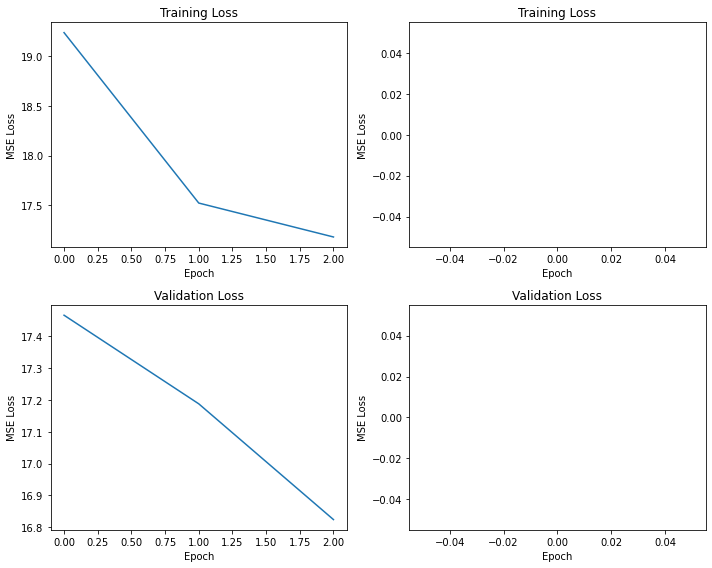

In [7]:
fig, axs = plt.subplots(2, 2, figsize = (10, 8))
n = 100

axs[0, 0].plot(np.arange(0, len(train_losses)), train_losses)
axs[0, 0].set_ylabel("MSE Loss")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_title("Training Loss")

axs[0, 1].plot(np.arange(n, len(train_losses)), train_losses[n:])
axs[0, 1].set_ylabel("MSE Loss")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_title("Training Loss")

axs[1, 0].plot(np.arange(0, len(val_losses)), val_losses)
axs[1, 0].set_ylabel("MSE Loss")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_title("Validation Loss")

axs[1, 1].plot(np.arange(n, len(val_losses)), val_losses[n:])
axs[1, 1].set_ylabel("MSE Loss")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_title("Validation Loss")

plt.tight_layout()
plt.show()

In [8]:
# NOTE: MÅSKE TRÆN PÅ HELE TRÆNINGSSÆTTET I STEDET OG BRUG DET RIGTIGE VALIDATION SET TIL VALIDERING

In [15]:
a = x[0]
a = a.reshape((1, a.shape[0], a.shape[1], a.shape[2]))
a = a.to(device, dtype = torch.float)
b = AE.encode(a)
print(b.shape)
c = AE.decode(b)
print(c.shape)

torch.Size([1, 10, 7, 7])
torch.Size([1, 256, 4, 4])
